# Example of first-stage data analysis of cockroach data from EScope

## Preliminaries

Install the escope python modules:

In [ ]:
!pip install escope

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.2/500.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.5/270.5 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: distro
    Found existing installation: distro 1.7.0
    Uninstalling distro-1.7.0:
      Successfully uninstalled distro-1.7.0


Import the escope modules as well as numpy for math and matplotlib for plotting:

In [2]:
from escope.loader import Recording
from escope.spikex import rmsnoise, detectspikes

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [11, 4]

In [6]:
import escope
escope

<module 'escope' from '/home/wagenaar/.local/lib/python3.12/site-packages/escope/__init__.py'>

## Loading and inspecting data

Load some example data:

In [4]:
root = "https://raw.githubusercontent.com/wagenadl/escope/refs/heads/main/eg-data"
rec = Recording(f"{root}/20231030-154906.escope")

AttributeError: module 'urllib.request' has no attribute 'openurl'

It is always useful to do a basic plot to check that our data make sense. The "Recording" class makes that very easy:

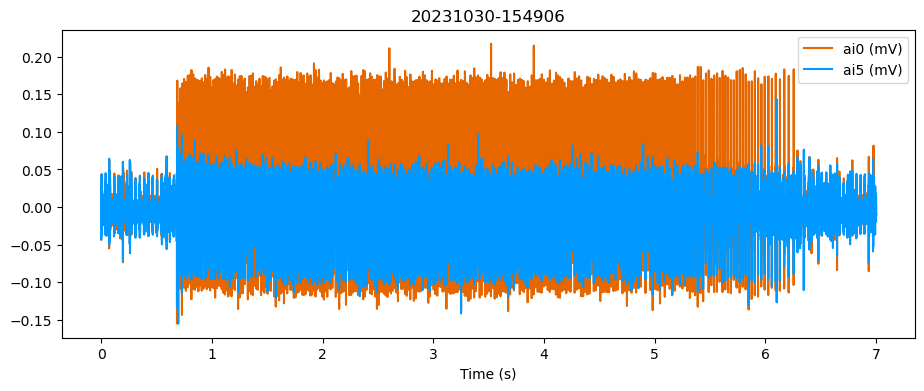

In [8]:
rec.plot()

## Extracting spike times and amplitudes

Let's convert the first channel to convenient units and plot the first few seconds:

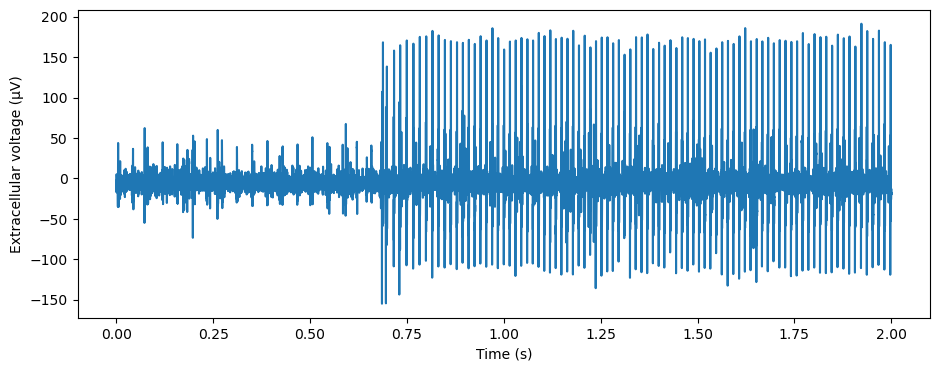

In [11]:
yy_uV = rec.data(0, "uV")
tt_s = rec.time()
use = tt_s < 2

plt.plot(tt_s[use], yy_uV[use])
plt.xlabel('Time (s)')
plt.ylabel('Extracellular voltage (µV)');

Evidently, the spikes can be classified into two units, one with amplitudes around 200 µV and the other quite a big smaller. There may be a third unit with a very low firing rate and intermediate amplitude which we are going to ignore for now. You could explore if you want.


Let's get an estimate for the RMS noise in the recording.

This is not as simple as calling

    np.std

on the data, as that would include the energy of the spikes in the estimate. *Bonus exercise:* Can you think of a good way to estimate the pure noise contribution? Type

    rmsnoise?

to read my solution.

In [15]:
rmsnoise?

In [17]:
noise = rmsnoise(yy_uV, percentile=10)
noise

7.0181689048448535

About 7 µV of noise. That's pretty good.


Let's select upward excursions above 100 µV as "big spikes" and plot them on top of the raw data. (*Question:* why pick the upward excursions rather than the downward excursions? Why not pick both?)

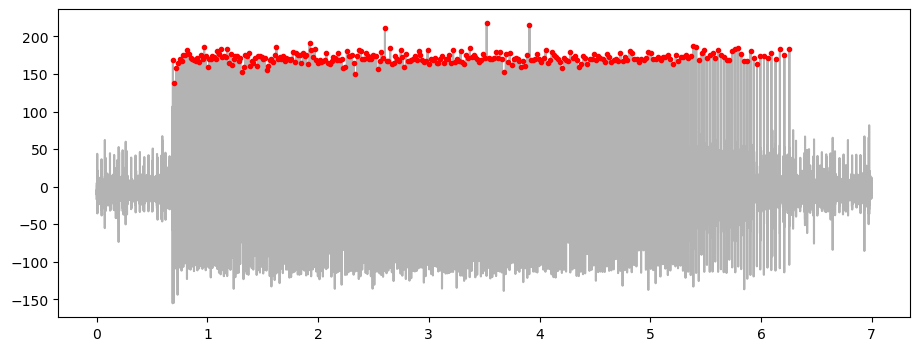

In [20]:
bigspikes = detectspikes(yy_uV, 100, polarity=1, upperthresh=300)
tt_big_s = tt_s[bigspikes]
yy_big_uV = yy_uV[bigspikes]

plt.plot(tt_s, yy_uV, color=[.7, .7, .7])
plt.plot(tt_big_s, yy_big_uV, 'r.');

You might want to zoom in further for closer inspection, but things look OK so far.

Next, select upward excursions between 5× the noise and 100 µV as "little spikes" and again zoom in to the first few seconds:

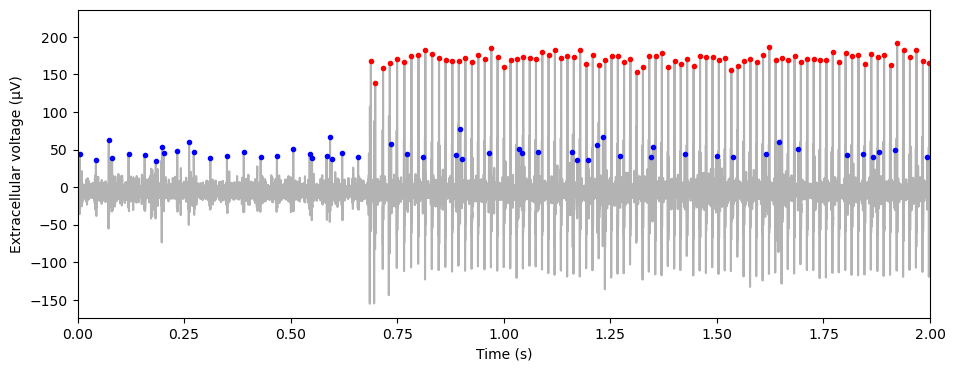

In [21]:
littlespikes = detectspikes(yy_uV, 5*noise, polarity=1, upperthresh=100)
tt_little_s = tt_s[littlespikes]
yy_little_uV = yy_uV[littlespikes]

plt.plot(tt_s, yy_uV, color=[.7, .7, .7])
plt.plot(tt_big_s, yy_big_uV, 'r.')
plt.plot(tt_little_s, yy_little_uV, 'b.')

plt.xlim(0, 2)

plt.xlabel('Time (s)')
plt.ylabel('Extracellular voltage (µV)');


(Note the repeated "plot" commands from the previous cell. To my knowledge, that's the easiest way in CoLab to combine plots in a single graph while also keeping a record of the intermediate steps.)



## Output to CSV file for future use

 Write the times and amplitudes of the big spikes to a file for processing in other software and to have a compact record of our intermediate results

In [22]:
with open(f"bigspikes-20231030-154906.csv", "w") as file:
    file.write('"Time (s)","Peak (µV)"\n')
    for t, v in zip(tt_big_s, yy_big_uV):
        file.write(f"{t:.3f},{v:.1f}\n")

(If your data get big, you might prefer alternative file formats. Check out the "ppersist" module in my code library at https://github.com/wagenadl/python-daw.)

## Exercises

### 1. Firing rates

Make a plot of the firing rate of each of the units as a function of time. *Hint:* Use
    
    np.hist

on the spike times.
   
What would be a reasonable bin size?

### 2. The other electrode

See if there are also multiple "units" on the second electrode. See if there is any connection between the spike timing of the "big" units of one electrode and the other. What do you think is happening here?

*Hint:*  You can use
  
    rec.data(1, "uV")

to access the data of the second channel. The time vector for the raw trace is the same for all channels.